In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
from scipy.linalg import expm, eig, logm
from qiskit import QuantumCircuit, QuantumRegister, BasicAer, execute
from operators.pauli_hamiltonian import PauliHamiltonian
from quantum_circuit.trotterization import trotter_electric, trotter_coupling
import matplotlib.pyplot as plt
from functools import reduce
from utils.matrix_operations import *

In [2]:
# Initialize Simulator
backend = BasicAer.get_backend('unitary_simulator')

In [3]:
# Nsites-site SG with cutoff L = M/2 with PBCs
# T = 2.
g = 1.0
h = 1.0
L = 2
M = 2*L
Nsites = 2
coefList = []
pauliList = []


# electric terms
for i in range(Nsites): # site
    for j in range(M): # flavor 1
        for k in range(j+1, M): # flavor 2
            coefList.append(1.0)
            pauliList.append({i*M+j: "Z", i*M+k: "Z"})
        

In [4]:
# potential terms
for i in range(Nsites): # site
# for i in range(Nsites-1):
    for j in range(M): # flavor of i-th site
        for k in range(M): # flavor of (i+1) site
            coefList.append(g**2/2.)
            coefList.append(g**2/2.)
            pauliList.append({i*M+j: "+", ((i+1)%Nsites)*M+k: "-"})
            pauliList.append({i*M+j: "-", ((i+1)%Nsites)*M+k: "+"})


In [5]:
# self interaction (or should be called as the transverse field?)
for i in range(Nsites): 
    for j in range(M): # flavor of i-th site
        #for k in range(j+1, M): # flavor 2
            #coefList.append(h)
            coefList.append(h)
            pauliList.append({i*M+j: "X"})
            #pauliList.append({i*M+k: "X"})
        

In [6]:
HSG = PauliHamiltonian(coefList, pauliList, n_sites=Nsites*M)
#exact = expm(-1j*HSG.matrix_form()*T)
#spectrum, _ = eig(exact)
#plt.matshow(HSG.matrix_form().real)
#print(HSG.matrix_form().real)
#print(exact)
#print(spectrum)

In [7]:
#print(HSG.matrix_form().real)

In [8]:
#print(exact)

In [9]:
#print(spectrum)

In [10]:
# # Kink solution
# # EY: defined T earlier T = 10.

# targ_vec = np.zeros(2**(Nsites*M))
# targ_vec[3] = 1.
# kink_evol = np.array([abs(np.matmul(expm(-1j*HSG.matrix_form()*T*(stp+1)/100), targ_vec))**2 for stp in range(100)])

In [11]:
# from matplotlib.animation import FuncAnimation

# def base_change(n, base, n_digits):
#     num_str = ''
#     for i in range(n_digits)[::-1]:
#         num_str += str(n//(base**i))
#         n -= (n//(base**i))*(base**i)
#     return num_str

# fig, ax = plt.subplots(figsize=(20,5))
# xdata, ydata = [], []
# #target_idx = range(2**(Nsites*M))
# target_idx = np.array([0, 3, 12, 15, 48, 51, 60, 63, 192, 195, 204, 207, 240, 243, 252, 255])
# xlist = [base_change(i, 4, 4) for i in target_idx]
# ln, = ax.plot(xlist, kink_evol[0][target_idx])
# plt.xticks(rotation = 90)

# def init():
#     ax.set_ylim(0, 1.1)
#     return ln,

# def update(frame):
#     xdata.append(xlist)
#     ydata.append(kink_evol[frame][target_idx])
#     ln.set_data(xlist, kink_evol[frame][target_idx])
#     return ln,

# ani = FuncAnimation(fig, update, frames=100,
#                     init_func=init, blit=True)

# from IPython.display import HTML
# HTML(ani.to_jshtml())

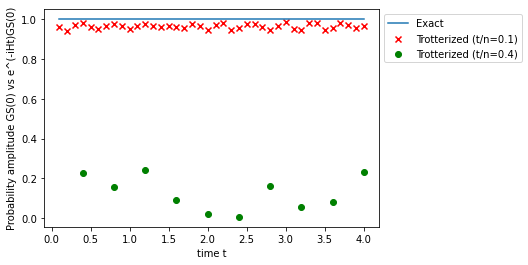

In [12]:
trot_evol_sg = []
trot2_evol_sg = []
trot4_evol_sg = []
exact_evol_sg = []
T = 4.0
n_steps = 40
in_state = np.zeros(2**(Nsites*M))
in_state[0] = 1.0
# Construct Circuit
qr = QuantumRegister(Nsites*M, 'qr')
circ = QuantumCircuit(qr)
circ2 = QuantumCircuit(qr)
circ4 = QuantumCircuit(qr)
for stp in range(n_steps):
    # measure <0|U|0> for each Trotter step
    
    # electric terms
    for i in range(Nsites): # site
        for j in range(M): # flavor 1
            for k in range(j+1, M): # flavor 2
                trotter_electric(circ, [i*M+j, i*M+k], 1.0, T/n_steps, unitary_sim = False, further_opt = False)
                
    # potential terms
    for i in range(Nsites): # site
        for j in range(M): # flavor of i-th site
            for k in range(M): # flavor of (i+1) site
                trotter_coupling(circ, [i*M+j, ((i+1)%Nsites)*M+k], g**2/2., T/n_steps, further_opt = False)
                
    # self interaction (or should be called as the transverse field?)
    for i in range(Nsites): 
        for j in range(M): # flavor of i-th site
            circ.rx(2*h* T/n_steps, qr[i*M+j])

    job = execute(circ, backend)
    #eigvals, _ = eig(job.result().get_unitary(circ, decimals=3))
    trot_evol_sg.append(job.result().get_unitary(circ, decimals=6))
    
    # larger t/n
    if stp%2== 0: 
        # electric terms
        for i in range(Nsites): # site
            for j in range(M): # flavor 1
                for k in range(j+1, M): # flavor 2
                    trotter_electric(circ2, [i*M+j, i*M+k], 1.0, T*2/n_steps, unitary_sim = False, further_opt = False)
                
        # potential terms
        for i in range(Nsites): # site
            for j in range(M): # flavor of i-th site
                for k in range(M): # flavor of (i+1) site
                    trotter_coupling(circ2, [i*M+j, ((i+1)%Nsites)*M+k], g**2/2., T*2/n_steps, further_opt = False)
        
        # self interaction (or should be called as the transverse field?)
        for i in range(Nsites): 
            for j in range(M): # flavor of i-th site
                # for k in range(j+1, M):
                circ2.rx(2*h* T*2/n_steps, qr[i*M+j])
            
        job = execute(circ2, backend)
        #eigvals, _ = eig(job.result().get_unitary(circ, decimals=3))
        trot2_evol_sg.append(job.result().get_unitary(circ2, decimals=6))
    
    # larger t/n
    if stp%4 == 0: 
        # electric terms
        for i in range(Nsites): # site
            for j in range(M): # flavor 1
                for k in range(j+1, M): # flavor 2
                    trotter_electric(circ4, [i*M+j, i*M+k], 1.0, T*4/n_steps, unitary_sim = False, further_opt = False)
                
        # potential terms
        for i in range(Nsites): # site
            for j in range(M): # flavor of i-th site
                for k in range(M): # flavor of (i+1) site
                    trotter_coupling(circ4, [i*M+j, ((i+1)%Nsites)*M+k], g**2/2., T*4/n_steps, further_opt = False)
        
        # self interaction (or should be called as the transverse field?)
        for i in range(Nsites): 
            for j in range(M): # flavor of i-th site
                circ4.rx(2*h* T*4/n_steps, qr[i*M+j])
            
        job = execute(circ4, backend)
        #eigvals, _ = eig(job.result().get_unitary(circ, decimals=3))
        trot4_evol_sg.append(job.result().get_unitary(circ4, decimals=6))
    
    #exact_evol.append(expm(-1j*HSG.matrix_form()*T*(stp+1)/n_steps))
exact_evol_sg = [expm(-1j*HSG.matrix_form()*T*(stp+1)/100) for stp in range(100)]


evals, evecs= np.linalg.eigh(HSG.matrix_form())
targ_vec = np.reshape(evecs[:, 0], [-1, 1])
plt.scatter(np.arange(1, n_steps+1)*(T/n_steps), [abs(reduce(np.matmul, [np.conjugate(targ_vec).T, trot_evol_sg[i], targ_vec]))[0, 0]**2 for i in range(n_steps)], label='Trotterized (t/n=0.1)', marker="x", color='red')
plt.scatter((np.arange(n_steps//4)+1)*(T*4/n_steps), [abs(reduce(np.matmul, [np.conjugate(targ_vec).T, trot4_evol_sg[i], targ_vec]))[0, 0]**2 for i in range(n_steps//4)], label='Trotterized (t/n=0.4)', marker="o", color='green')
plt.plot(np.arange(1, n_steps+1)*(T/n_steps), [abs(reduce(np.matmul, [np.conjugate(targ_vec).T, exact_evol_sg[i], targ_vec]))[0, 0]**2 for i in range(n_steps)], label='Exact')

plt.xlabel("time t")
plt.ylabel("Probability amplitude GS(0) vs e^(-iHt)GS(0)")
plt.legend(bbox_to_anchor=(1., 1))
plt.show()

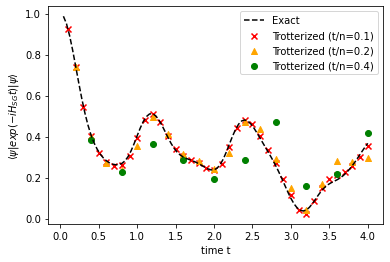

In [13]:
targ_vec = np.zeros(2**(Nsites*M))
targ_vec[3] = 1.
plt.scatter(np.arange(1, n_steps+1)*(T/n_steps), [abs(matmul([np.conjugate(targ_vec).T, trot_evol_sg[i], targ_vec])) for i in range(n_steps)], label='Trotterized (t/n=0.1)', marker="x", color='red')
plt.scatter((np.arange(n_steps//2)+1)*(T*2/n_steps), [abs(matmul([np.conjugate(targ_vec).T, trot2_evol_sg[i], targ_vec])) for i in range(n_steps//2)], label='Trotterized (t/n=0.2)', marker="^", color='orange')
plt.scatter((np.arange(n_steps//4)+1)*(T*4/n_steps), [abs(matmul([np.conjugate(targ_vec).T, trot4_evol_sg[i], targ_vec])) for i in range(n_steps//4)], label='Trotterized (t/n=0.4)', marker="o", color='green')
plt.plot(np.arange(1, 100+1)*(T/100), [abs(matmul([np.conjugate(targ_vec).T, exact_evol_sg[i], targ_vec])) for i in range(100)], label='Exact', linestyle='--', color='k')
#plt.plot(np.arange(1, n_steps+1)*(T/n_steps), [abs(matmul([np.conjugate(targ_vec).T, exact_evol[i], targ_vec])) for i in range(n_steps)], label='Exact')

plt.xlabel("time t")
plt.ylabel(r"$ \langle \psi |exp(-iH_{SG}t)|\psi \rangle $")
plt.legend(bbox_to_anchor=(1., 1))
plt.show()

In [14]:
# exact_evol_2 = [expm(-1j*HSG.matrix_form()*T*(stp+1)/100) for stp in range(100)]

In [17]:
circ.draw()

»
qr_0: ──■─────────────────────────────────────────────────────■────■──»
      ┌─┴─┐┌─────────┐┌───────────┐┌──────────┐┌───────────┐┌─┴─┐  │  »
qr_1: ┤ X ├┤ U1(0.1) ├┤ U3(π,0,π) ├┤ U1(-0.1) ├┤ U3(π,0,π) ├┤ X ├──┼──»
      └───┘└─────────┘└───────────┘└──────────┘└───────────┘└───┘┌─┴─┐»
qr_2: ───────────────────────────────────────────────────────────┤ X ├»
                                                                 └───┘»
qr_3: ────────────────────────────────────────────────────────────────»
                                                                      »
qr_4: ──■─────────────────────────────────────────────────────■────■──»
      ┌─┴─┐┌─────────┐┌───────────┐┌──────────┐┌───────────┐┌─┴─┐  │  »
qr_5: ┤ X ├┤ U1(0.1) ├┤ U3(π,0,π) ├┤ U1(-0.1) ├┤ U3(π,0,π) ├┤ X ├──┼──»
      └───┘└─────────┘└───────────┘└──────────┘└───────────┘└───┘┌─┴─┐»
qr_6: ───────────────────────────────────────────────────────────┤ X ├»
                                                                 └───┘»
qr_7: ────────────────────────────────────────────────────────────────»
                                                                      »
«                                                                            »
«qr_0: ───────────────────────────────────────────────────■────■─────────────»
«                                                         │    │             »
«qr_1: ───────────────────────────────────────────────────┼────┼───────■─────»
«      ┌─────────┐┌───────────┐┌──────────┐┌───────────┐┌─┴─┐  │     ┌─┴─┐   »
«qr_2: ┤ U1(0.1) ├┤ U3(π,0,π) ├┤ U1(-0.1) ├┤ U3(π,0,π) ├┤ X ├──┼─────┤ X ├───»
«      └─────────┘└───────────┘└──────────┘└───────────┘└───┘┌─┴─┐┌──┴───┴──┐»
«qr_3: ──────────────────────────────────────────────────────┤ X ├┤ U1(0.1) ├»
«                                                            └───┘└─────────┘»
«qr_4: ───────────────────────────────────────────────────■────■─────────────»
«                                                         │    │             »
«qr_5: ───────────────────────────────────────────────────┼────┼───────■─────»
«      ┌─────────┐┌───────────┐┌──────────┐┌───────────┐┌─┴─┐  │     ┌─┴─┐   »
«qr_6: ┤ U1(0.1) ├┤ U3(π,0,π) ├┤ U1(-0.1) ├┤ U3(π,0,π) ├┤ X ├──┼─────┤ X ├───»
«      └─────────┘└───────────┘└──────────┘└───────────┘└───┘┌─┴─┐┌──┴───┴──┐»
«qr_7: ──────────────────────────────────────────────────────┤ X ├┤ U1(0.1) ├»
«                                                            └───┘└─────────┘»
«                                                                         »
«qr_0: ──────────────────────────────────────────────────────■────────────»
«                                                            │            »
«qr_1: ──────────────────────────────────────────────────────┼────■────■──»
«       ┌─────────┐ ┌───────────┐ ┌──────────┐┌───────────┐  │  ┌─┴─┐  │  »
«qr_2: ─┤ U1(0.1) ├─┤ U3(π,0,π) ├─┤ U1(-0.1) ├┤ U3(π,0,π) ├──┼──┤ X ├──┼──»
«      ┌┴─────────┴┐└┬──────────┤┌┴──────────┤└───────────┘┌─┴─┐└───┘┌─┴─┐»
«qr_3: ┤ U3(π,0,π) ├─┤ U1(-0.1) ├┤ U3(π,0,π) ├─────────────┤ X ├─────┤ X ├»
«      └───────────┘ └──────────┘└───────────┘             └───┘     └───┘»
«qr_4: ──────────────────────────────────────────────────────■────────────»
«                                                            │            »
«qr_5: ──────────────────────────────────────────────────────┼────■────■──»
«       ┌─────────┐ ┌───────────┐ ┌──────────┐┌───────────┐  │  ┌─┴─┐  │  »
«qr_6: ─┤ U1(0.1) ├─┤ U3(π,0,π) ├─┤ U1(-0.1) ├┤ U3(π,0,π) ├──┼──┤ X ├──┼──»
«      ┌┴─────────┴┐└┬──────────┤┌┴──────────┤└───────────┘┌─┴─┐└───┘┌─┴─┐»
«qr_7: ┤ U3(π,0,π) ├─┤ U1(-0.1) ├┤ U3(π,0,π) ├─────────────┤ X ├─────┤ X ├»
«      └───────────┘ └──────────┘└───────────┘             └───┘     └───┘»
«         ┌───┐                                                           »
«qr_0: ───┤ X ├───────────────────────────────────■───────────────────────»
«         └─┬─┘                                   │        

In [18]:
print(circ)

                                                                      »
qr_0: ──■─────────────────────────────────────────────────────■────■──»
      ┌─┴─┐┌─────────┐┌───────────┐┌──────────┐┌───────────┐┌─┴─┐  │  »
qr_1: ┤ X ├┤ U1(0.1) ├┤ U3(π,0,π) ├┤ U1(-0.1) ├┤ U3(π,0,π) ├┤ X ├──┼──»
      └───┘└─────────┘└───────────┘└──────────┘└───────────┘└───┘┌─┴─┐»
qr_2: ───────────────────────────────────────────────────────────┤ X ├»
                                                                 └───┘»
qr_3: ────────────────────────────────────────────────────────────────»
                                                                      »
qr_4: ──■─────────────────────────────────────────────────────■────■──»
      ┌─┴─┐┌─────────┐┌───────────┐┌──────────┐┌───────────┐┌─┴─┐  │  »
qr_5: ┤ X ├┤ U1(0.1) ├┤ U3(π,0,π) ├┤ U1(-0.1) ├┤ U3(π,0,π) ├┤ X ├──┼──»
      └───┘└─────────┘└───────────┘└──────────┘└───────────┘└───┘┌─┴─┐»
qr_6: ──────────────────────────────────────────────────────────

In [15]:
# T = 4.0
# n_steps = 40
# in_state = np.zeros(2**(Nsites*M))
# in_state[0] = 1.0

# targ_vec = np.zeros(2**(Nsites*M))
# targ_vec[3] = 1.
# #plt.scatter(np.arange(1, n_steps+1)*(T/n_steps), [abs(matmul([np.conjugate(targ_vec).T, trot_evol_sg[i], targ_vec])) for i in range(n_steps)], label='Trotterized (t/n=0.1)', marker="x", color='red')
# #plt.scatter((np.arange(n_steps//2)+1)*(T*2/n_steps), [abs(matmul([np.conjugate(targ_vec).T, trot2_evol_sg[i], targ_vec])) for i in range(n_steps//2)], label='Trotterized (t/n=0.2)', marker="^", color='orange')
# #plt.scatter((np.arange(n_steps//4)+1)*(T*4/n_steps), [abs(matmul([np.conjugate(targ_vec).T, trot4_evol_sg[i], targ_vec])) for i in range(n_steps//4)], label='Trotterized (t/n=0.4)', marker="o", color='green')
# plt.plot(np.arange(1, 100+1)*(T/100), [abs(matmul([np.conjugate(targ_vec).T, exact_evol_2[i], targ_vec])) for i in range(100)], label='Exact', linestyle='--', color='k')
# #plt.plot(np.arange(1, n_steps+1)*(T/n_steps), [abs(matmul([np.conjugate(targ_vec).T, exact_evol[i], targ_vec])) for i in range(n_steps)], label='Exact')

# plt.xlabel("time t")
# plt.ylabel(r"$ \langle \psi |exp(-iH_{SG}t)|\psi \rangle $")
# plt.legend(bbox_to_anchor=(1., 1))
# plt.show()